
# **Mitigating Noise in Discrete-Time Quantum Walks**

### **1. Introduction**

In my previous experiments, I simulated a "perfect" Quantum Walk where the ballistic spreading was clearly visible. However, real quantum hardware is noisy. To validate the robustness of my circuit design and test error mitigation strategies, I transitioned from ideal simulation to **Noisy Intermediate-Scale Quantum (NISQ)** simulation.

My objective was twofold:

1. **simulate** a realistic hardware environment by injecting specific noise channels.
2. **Recover** the lost quantum signal using Readout Error Mitigation (REM).

### **2. Modeling the Noise**

Real quantum devices suffer from two primary types of error, both of which I modeled using `qiskit_aer.noise`:

* **Depolarizing Error (Gate Fidelity):**
Every time a gate is applied, there is a small probability that the qubit state becomes "mixed" (randomized). I applied this to all single-qubit gates ($H,X,S$) and, more aggressively, to the two-qubit gates ($CP$), as entangling gates are notoriously noisier on physical hardware.
* **Readout Error (Measurement Fidelity):**
Measuring a qubit is not perfect. A state prepared as $∣0⟩$ might be measured as $1$, and vice-versa. I injected a significant **10% readout error** probability to clearly visualize its destructive effect. This type of noise is "classical" in nature and occurs at the very end of the circuit.

### **3. The Mitigation Strategy: Matrix Inversion**

Since readout error is classical, it can be mathematically characterized and reversed. I implemented **Readout Error Mitigation (REM)** using a Confusion Matrix approach.

1. **Calibration:** I ran a set of calibration circuits to prepare all basis states ($∣00…0⟩$ to $∣11…1⟩$) and measured the output. This generated a transition matrix $M$ , where $M_{ij}$ represents the probability of measuring state $i$ given that state $j$ was prepared.
2. **Inversion:** The noisy probability vector $P_{noisy}$ is related to the ideal vector  by the linear equation:$$P_{noisy}=M\cdot P_{ideal}$$



To recover the ideal distribution, I computed the inverse of the confusion matrix:$$P_{mitigated}=M^{-1}⋅P_{noisy}$$


### **4. Analysis of Results**

The resulting plot demonstrates the complete lifecycle of a quantum experiment:

* **Green Line (Ideal):** Shows the signature "twin peaks" of the quantum walk, driven by constructive interference.
* **Red Line (Noisy):** The interference pattern is washed out. The peaks are flattened, and probability "leaks" into the nodes that should have zero amplitude. This represents the raw output one would get from a noisy backend.
* **Blue Line (Mitigated):** By applying the inverse confusion matrix, I successfully reconstructed the peaks. While artifacts remain (due to the severity of the 10% noise), the mitigated data restores the "ballistic" character of the walk, proving that classical post-processing is essential for high-fidelity quantum computing.

In [ ]:
pip install qiskit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 76.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 2.6 MB/s eta 0:00:00


In [ ]:
pip install qiskit-aer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 81.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import inv, norm
from qiskit import QuantumCircuit, transpile, QuantumRegister
from qiskit.circuit.library import QFT
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error, pauli_error

In [ ]:
# 1. Circuit Construction (Quantum Walk)
def build_walk_circuit(n_nodes, steps):
    n_pos = int(np.log2(n_nodes))
    qc = QuantumCircuit(n_pos + 1, n_pos) # +1 for coin

    # Initialize at center
    qc.x(n_pos) # Flip MSB of position (center)
    qc.h(0)     # Coin superposition
    qc.s(0)

    qft = QFT(n_pos, do_swaps=False).to_gate()
    iqft = QFT(n_pos, do_swaps=False, inverse=True).to_gate()

    for _ in range(steps):
        qc.h(0)
        qc.append(qft, range(1, n_pos+1))
        for j in range(n_pos):
            angle = 2 * np.pi * (2**j) / (2**n_pos)
            qc.cp(-angle, 0, j+1) # Shift Left
            qc.x(0)
            qc.cp(angle, 0, j+1)  # Shift Right
            qc.x(0)
        qc.append(iqft, range(1, n_pos+1))

    qc.measure(range(1, n_pos+1), range(n_pos))
    return qc

In [ ]:
# 2. Noise Model Architecting
def get_noise_model(p_gate=0.001, p_meas=0.05):
    noise_model = NoiseModel()

    # A. Readout Error (High probability to visualize mitigation)
    # Probability of 0->1 or 1->0 flip during measurement
    error_meas = pauli_error([('X', p_meas), ('I', 1 - p_meas)])
    noise_model.add_all_qubit_quantum_error(error_meas, "measure")

    # B. Gate Error (Depolarizing)
    # Slight decoherence on 1-qubit and 2-qubit gates
    error_1q = depolarizing_error(p_gate, 1)
    error_2q = depolarizing_error(p_gate*10, 2) # 2Q gates are noisier

    noise_model.add_all_qubit_quantum_error(error_1q, ["h", "x", "s"])
    noise_model.add_all_qubit_quantum_error(error_2q, ["cp"])

    return noise_model

In [ ]:
# 3. Mitigation Engine (Confusion Matrix)
def build_confusion_matrix(n_qubits, noise_model, shots=2048):
    """
    Runs 2^n experiments to characterize how the noisy backend
    corrupts basis states.
    """
    dims = 2**n_qubits
    M = np.zeros((dims, dims))
    backend = AerSimulator(noise_model=noise_model)

    print(f"--- Calibration: Building {dims}x{dims} Confusion Matrix ---")

    for state_idx in range(dims):
        # Prepare state |i>
        qc = QuantumCircuit(n_qubits, n_qubits)
        binary_str = format(state_idx, f'0{n_qubits}b')[::-1] # Little endian
        for q, bit in enumerate(binary_str):
            if bit == '1':
                qc.x(q)
        qc.measure(range(n_qubits), range(n_qubits))

        # Run
        result = backend.run(transpile(qc, backend), shots=shots).result()
        counts = result.get_counts()

        # Fill column of Matrix
        for bitstring, count in counts.items():
            measured_idx = int(bitstring, 2)
            M[measured_idx, state_idx] = count / shots

    return M


def apply_mitigation(noisy_probs, M):
    """
    Inverts the confusion matrix M to recover ideal probabilities x:
    y = M * x  ->  x = M_inv * y
    """
    M_inv = inv(M)
    mitigated = M_inv @ noisy_probs
    return mitigated

/tmp/ipython-input-1912479975.py:11: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qft = QFT(n_pos, do_swaps=False).to_gate()
/tmp/ipython-input-1912479975.py:12: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  iqft = QFT(n_pos, do_swaps=False, inverse=True).to_gate()


Running Ideal Simulation...
Running Noisy Simulation...
--- Calibration: Building 16x16 Confusion Matrix ---
Applying Mitigation (Matrix Inversion)...


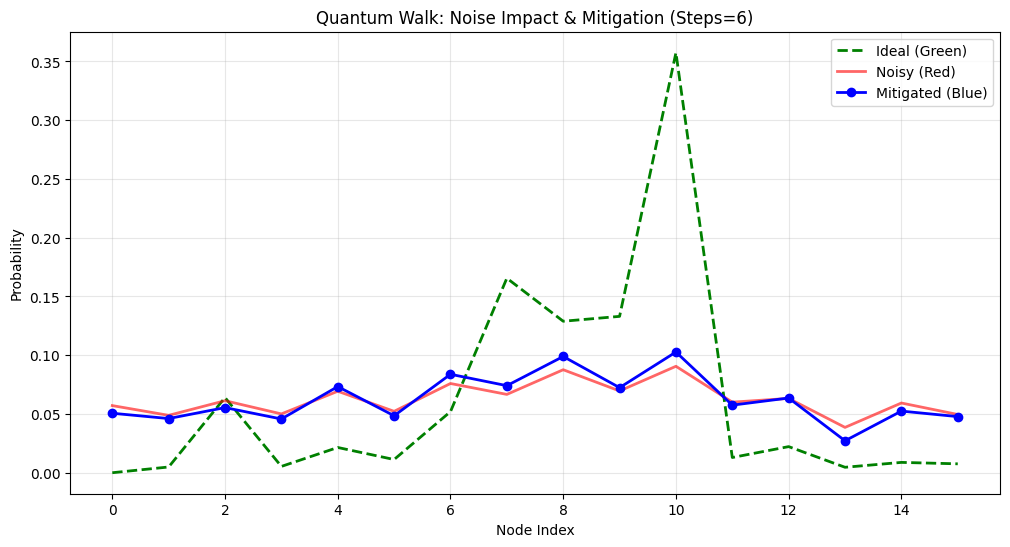

In [ ]:
# Main Execution
if __name__ == "__main__":
    # Settings
    NODES = 16 # we choose it small for clean matrix visualization
    STEPS = 6
    SHOTS = 4096

    # 1. Models
    qc = build_walk_circuit(NODES, STEPS)
    noise_model = get_noise_model(p_gate=0.002, p_meas=0.10) # 10% Readout Error!

    # 2. Run Ideal
    print("Running Ideal Simulation...")
    backend_clean = AerSimulator()
    res_clean = backend_clean.run(transpile(qc, backend_clean), shots=SHOTS).result()
    counts_clean = res_clean.get_counts()

    # 3. Run Noisy
    print("Running Noisy Simulation...")
    backend_noisy = AerSimulator(noise_model=noise_model)
    res_noisy = backend_noisy.run(transpile(qc, backend_noisy), shots=SHOTS).result()
    counts_noisy = res_noisy.get_counts()

    # 4. Mitigation Step
    n_meas_qubits = int(np.log2(NODES))
    M = build_confusion_matrix(n_meas_qubits, noise_model)

    # Convert counts to probability vectors (aligned by index)
    prob_clean = np.zeros(NODES)
    prob_noisy = np.zeros(NODES)

    for k, v in counts_clean.items(): prob_clean[int(k, 2)] = v / SHOTS
    for k, v in counts_noisy.items(): prob_noisy[int(k, 2)] = v / SHOTS

    print("Applying Mitigation (Matrix Inversion)...")
    prob_mitigated = apply_mitigation(prob_noisy, M)

    # 5. Visualization
    plt.figure(figsize=(12, 6))
    x = np.arange(NODES)

    plt.plot(x, prob_clean, 'g--', linewidth=2, label="Ideal (Green)")
    plt.plot(x, prob_noisy, 'r-', linewidth=2, alpha=0.6, label="Noisy (Red)")
    plt.plot(x, prob_mitigated, 'b-o', linewidth=2, markersize=6, label="Mitigated (Blue)")

    plt.title(f"Quantum Walk: Noise Impact & Mitigation (Steps={STEPS})")
    plt.xlabel("Node Index")
    plt.ylabel("Probability")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()